# Model Building & Applying

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
import os
import dill as pickle
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
warnings.filterwarnings("ignore")

In [2]:
class PreProcessing(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def transform(self, df):

        feature_vector = ['Pclass', 'Sex', 'Age', 'Embarked', 'Cabin_', 'NameLength', 'familySize', 'isAlone', 'fareGroup']
        self.impute_missing_values(df)
        df['Pclass'] = df['Pclass'].astype(int)
        df['Age'] = df['Age'].astype(int)
        df['SibSp'] = df['SibSp'].astype(int)
        df['Parch'] = df['Parch'].astype(int)
        df['fareGroup'] = pd.cut(df.Fare, bins = 4, labels=[1,2,3,4]).astype(int)
        df['Cabin_'] = df['Cabin'].apply(lambda x: 0 if x is np.nan else 1).astype(int)
        df['NameLength'] = df['Name'].apply(len).astype(int)
        df['familySize'] = (df['SibSp'] + df['Parch'] + 1).astype(int)
        df['isAlone'] = df['familySize'].apply(lambda x: 1 if x == 1 else 0).astype(int)
        df = df[feature_vector]

        sex_values = {'female': 0, 'male': 1}
        embarked_values = {'S': 0, 'C': 1, 'Q': 2}
        df.replace({'Sex': sex_values, 'Embarked': embarked_values}, inplace=True)

        return df.as_matrix()

    def fit(self, df, y=None, **fit_params):
        return self
    
    def impute_missing_values(self, df):
        df['Age'] = df['Age'].apply(self.impute_age)
        df['Embarked'] = df['Embarked'].fillna('S')
        pass
    
    def impute_age(self, x):
        from random import randint
        from math import isnan
        if isnan(x):
            imputation_tray = [24, 28, 29]
            return imputation_tray[randint(0,2)]
        else:
            return x


# if __name__ == '__main__':
#     print(os.path.dirname(os.path.abspath(__file__)))
#     model = build_and_train()

#     filename = 'model_v1.pk'
#     with open('D:\Workplace\Self\Django\Insightish\media' + filename, 'wb') as file:
#         pickle.dump(model, file)


In [3]:
def build_model():
    data = pd.read_csv(r'.\Data\train_processed.csv')

    feature_vector = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Cabin', 'Fare', 'Name']
    X_train = data[feature_vector]
    y_train = data['Survived']

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state = 0)

    pipe = make_pipeline(PreProcessing(),
                         XGBClassifier())

    param_grid = {'xgbclassifier__max_depth': [2, 3, 6, 8],
                  'xgbclassifier__min_child_weight': [2, 3, 5, 8],
                  'xgbclassifier__subsample': [0.8, 0.9, 1.0],
                  'xgbclassifier__colsample_bytree': [0.5, 0.6],
                  'xgbclassifier__n_estimators': [100, 150, 200, 300]}
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    
#     return grid.best_estimator_
    model = grid.best_estimator_
    y_pred = model.predict(X_test)

    print(accuracy_score(y_test, y_pred))
    return y_test, y_pred


In [4]:
y_test, y_pred = build_model()

0.8379888268156425


In [19]:
y_test.shape

(179,)

In [10]:
results = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

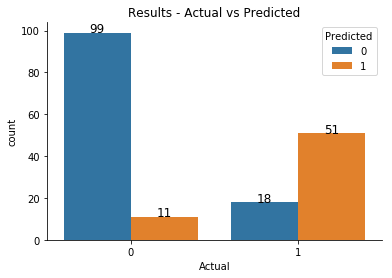

In [20]:
# fig = plt.figure(num=None, figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')

ax = sns.countplot(x = 'Actual', data=results, hue='Predicted')
sns.despine()
title = "Results - Actual vs Predicted"
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2.,
                height + .12,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=12,
                family='sans-serif')
plt.title(title)
plt.savefig(r'.\Media\\' + title + '.png')

In [5]:
# test_df = pd.read_csv(r'.\Data\test.csv')

# test_df['Survived'] = model.predict(test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Cabin', 'Fare', 'Name']])

# test_df[['PassengerId', 'Survived']].to_csv(r'.\Data\xgb_submission.csv', index=False)